# Importing the related libraries and reading the datasets.

In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Exploring the data

In [555]:
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [556]:
def showMissingCounts(data):
    for column in data.columns:
        print(str(column) + " : " + str(data[column].isna().sum()))
showMissingCounts(train_data)

PassengerId : 0
Survived : 0
Pclass : 0
Name : 0
Sex : 0
Age : 177
SibSp : 0
Parch : 0
Ticket : 0
Fare : 0
Cabin : 687
Embarked : 2


"Cabin" kolonunda çok fazla boş veri olduğu için bu kolonu tamamen çıkartmaya karar verdik.

In [557]:
train_data = train_data.drop(columns=["Name", "Cabin", "Ticket"])
train_data["Sex"].replace(["male","female"], [0,1], inplace=True)
train_data["Embarked"].replace(["C","Q", "S"], [0,1,2], inplace=True)

In [558]:
showMissingCounts(train_data)

PassengerId : 0
Survived : 0
Pclass : 0
Sex : 0
Age : 177
SibSp : 0
Parch : 0
Fare : 0
Embarked : 2


In [559]:
def plotCorrelationMatrix(correlationMatrix): 
    plt.figure(figsize=(10,10))
    sns.heatmap(correlationMatrix,linewidths=0.6,fmt=".2f",annot=True,cmap="icefire")
    plt.show()

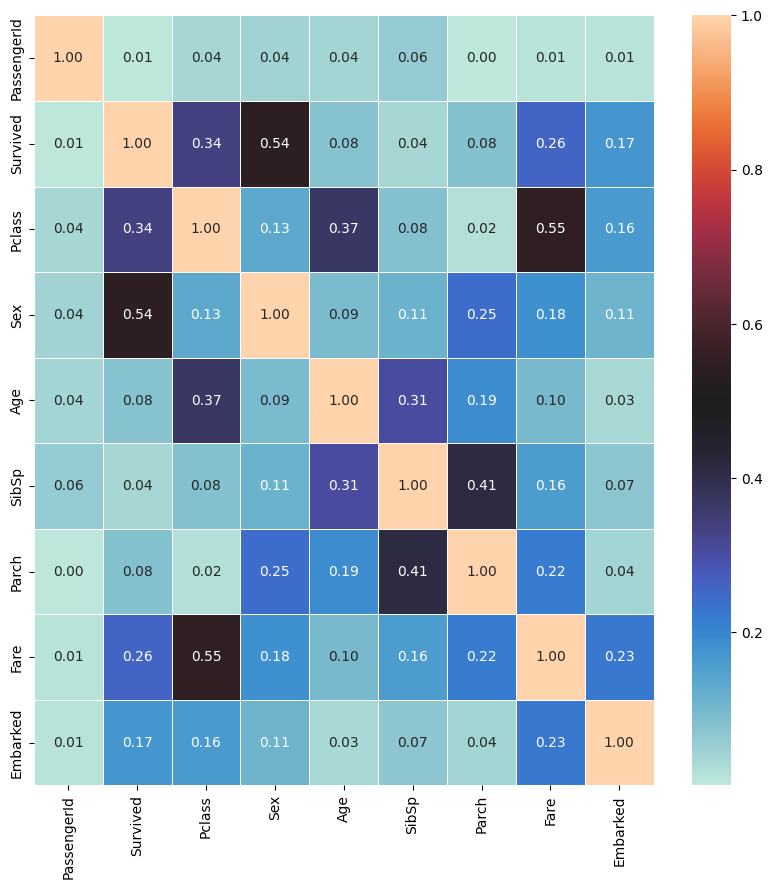

In [560]:
correlationMatrix = train_data.corr().abs()
plotCorrelationMatrix(correlationMatrix)

Korelasyonu kolonlar arasındaki benzerlikleri tespit etmek için yaptık ve sonucunda kolonların birbirinden bağımsız olduğunu bulduğumuz için herhangi bir kolonu drop etmedik. Bu yöntemin ismine most probable value denilmektedir. Bu korelasyonu "Age" kolonundaki boşlukları doldurmak için de kullanabiliriz. "Age" kolonunun en korele olduğu kolon "PClas" olduğu ancak korelasyonun 0.37 çıkması weak associate olduğu için korelasyon yerine daha farklı bir metod ile impute etmeye karar verdik. Missing value imputation için kullanılabilecek istatistikleri hesaplıyoruz.

In [561]:
ageList = train_data["Age"][train_data["Age"].notna()]

mode = st.mode(ageList)
median = st.median(ageList)
mean = round(st.mean(ageList),2)

ageStats = pd.DataFrame([[mode, median, mean]], columns=["Mode", "Median", "Mean"], index=["Age"])
ageStats

,Mode,Median,Mean
Age,24.0,28.0,29.7


In [562]:
def plotColumnHistogram(data_colum):
    plt.hist(train_data[data_colum], bins= int(max(train_data["Age"])), color = "blue", edgecolor="black")
    plt.title("Histogram of {} column".format(data_colum))
    plt.xlabel(data_colum)
    plt.ylabel("Frequency")

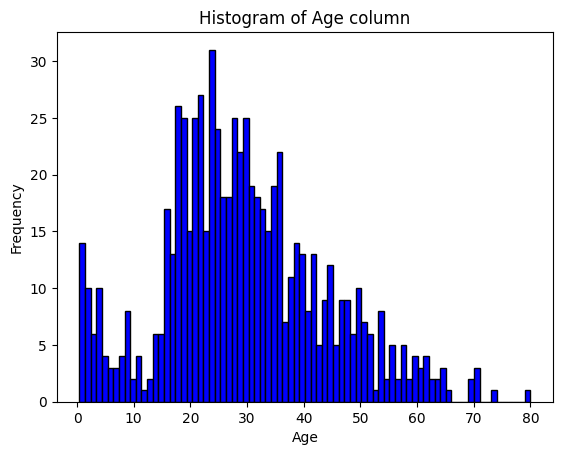

In [563]:
plotColumnHistogram("Age")

Verinin "Age" kolonununda dağılım normal yada uniform dağılımdan ziyade right skewed olduğu için bu kolondaki boşlukları mode kullanarak doldurmaya karar verdik. Bu sebeple mod değerini kullanmaya karar verdik. "Age" kolonundaki NaN olan verileri mod ile dolduracağız.

In [564]:
train_data[["Age"]] = train_data[["Age"]].fillna(ageStats["Mode"])
showMissingCounts(train_data)

PassengerId : 0
Survived : 0
Pclass : 0
Sex : 0
Age : 0
SibSp : 0
Parch : 0
Fare : 0
Embarked : 2


Korelasyonda embarın target attribute üzerinde bir etkisi olmadığını görüyoruz. zaten 2 satırda boşluk olduğu için bu satıları çıkartıyoruz.

In [565]:
train_data = train_data.dropna()
showMissingCounts(train_data)

PassengerId : 0
Survived : 0
Pclass : 0
Sex : 0
Age : 0
SibSp : 0
Parch : 0
Fare : 0
Embarked : 0


In [566]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2.0
1,2,1,1,1,38.0,1,0,71.2833,0.0
2,3,1,3,1,26.0,0,0,7.9250,2.0
3,4,1,1,1,35.0,1,0,53.1000,2.0
4,5,0,3,0,35.0,0,0,8.0500,2.0


Verimiz temizlendiğine göre artık modele sokmadan önce categoric olan verileri dummyfy edebilmemiz için numeric formlarını değiştiriyoruz.

In [567]:
train_data["Pclass"].replace([1, 2, 3], ["1st", "2nd", "3rd"], inplace=True)
train_data["Embarked"].replace([0, 1, 2], ["Cherbourg", "Queenstown", "Southampton"], inplace=True)

dummyfiedFeatures = ["Pclass", "Sex", "Embarked"]
dummyfiedDF = pd.get_dummies(train_data[dummyfiedFeatures], dtype=int)
dummyfiedDF

train_data = train_data.drop(columns=dummyfiedFeatures)
train_data = pd.concat([train_data, dummyfiedDF], axis=1)
train_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex,Pclass_1st,Pclass_2nd,Pclass_3rd,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,22.0,1,0,7.2500,0,0,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,1,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,1,1,0,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,0,1,0,0,1


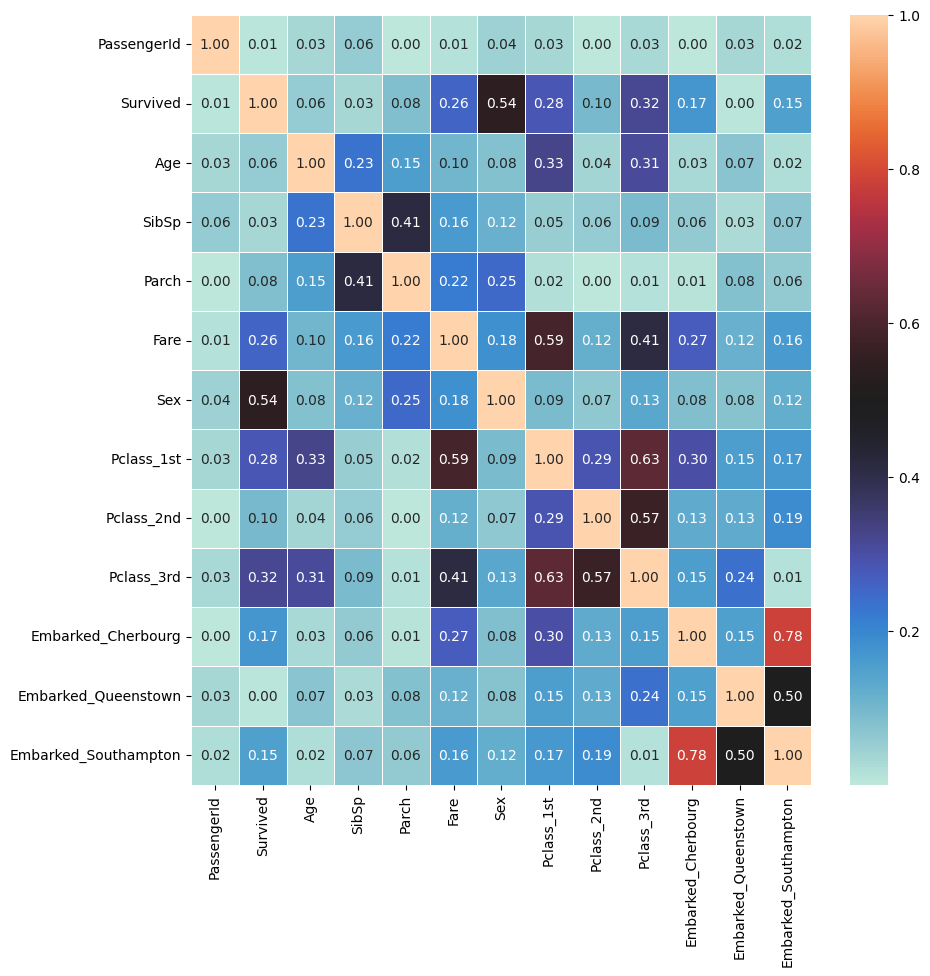

In [568]:
correlationMatrix = train_data.corr().abs()
plotCorrelationMatrix(correlationMatrix)

"Embarked_Quenstown" kolonunun target ile korelasyonu 0 olduğu için bu kolonu eleyebiliriz.

In [569]:
train_data = train_data.drop(columns=["Embarked_Queenstown"])
train_data.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex,Pclass_1st,Pclass_2nd,Pclass_3rd,Embarked_Cherbourg,Embarked_Southampton
0,1,0,22.0,1,0,7.2500,0,0,0,1,0,1
1,2,1,38.0,1,0,71.2833,1,1,0,0,1,0
2,3,1,26.0,0,0,7.9250,1,0,0,1,0,1
3,4,1,35.0,1,0,53.1000,1,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,0,1,0,1


Şimdi de boxplot ile outlier detection yapacağız.

{'whiskers': [<matplotlib.lines.Line2D at 0x1779c1bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x177a0c390>,
 'boxes': [<matplotlib.lines.Line2D at 0x177982010>],
 'medians': [<matplotlib.lines.Line2D at 0x177a0c750>],
 'fliers': [<matplotlib.lines.Line2D at 0x177a0f490>],
 'means': []}

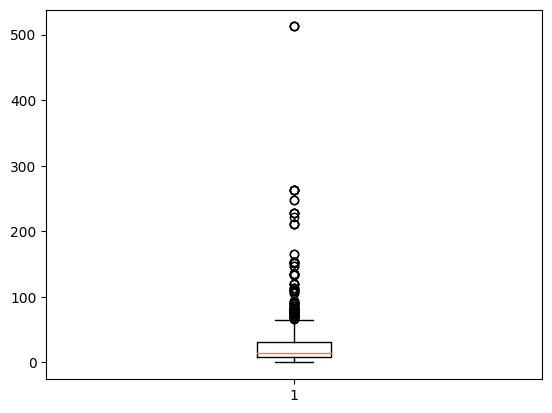

In [572]:
plt.boxplot(train_data["Fare"])

En son da target kolonumuzu daha güzel görünmesi için sona taşıyoruz.

In [ ]:
targetColumn = train_data.pop("Survived")
train_data.insert((len(train_data.columns)), "Survived", targetColumn)
train_data.head()

,PassengerId,Age,SibSp,Parch,Fare,Sex,Pclass_1st,Pclass_2nd,Pclass_3rd,Embarked_Cherbourg,Embarked_Southampton,Survived
0,1,22.0,1,0,7.2500,0,0,0,1,0,1,0
1,2,38.0,1,0,71.2833,1,1,0,0,1,0,1
2,3,26.0,0,0,7.9250,1,0,0,1,0,1,1
3,4,35.0,1,0,53.1000,1,1,0,0,0,1,1
4,5,35.0,0,0,8.0500,0,0,0,1,0,1,0
